In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')
# https://www.kaggle.com/fedesoriano/stroke-prediction-dataset 
df = pd.read_csv("../../data/healthcare-dataset-stroke-data.csv")

In [5]:
# Fill missing values
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

DecisionTreePip = Pipeline(steps=[ 
                               ('Scale',StandardScaler()),
                               ('DecisionTreeReg',DecisionTreeRegressor(random_state = 42))
                              ])

X = df[['age','gender','bmi']]
X.gender = X.gender.replace({'Male' : 0, 'Female' : 1 , 'Other' : -1}).astype(np.uint8)

# create a dataframe containing the missing values of X
missing = X[X.bmi.isna()]

# remove the missing values from X 
X = X.dropna()

# creates Y by removing bmi from X
Y = X.pop('bmi')

# fit the pipeline
DecisionTreePip.fit(X,Y)

# make the prediction 
predict_bmi = pd.Series(DecisionTreePip.predict(missing[['age', 'gender']]), index = missing.index)
df.loc[missing.index, 'bmi'] = predict_bmi

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
# Generate the data samples: Original, Oversampled, Undersampled
y = df[["stroke"]].copy()
X = df.copy()

In [7]:
# ALWAYS SPLIT THE DATA IN TRAIN AND TEST AND THEN OVERSAMPLE/DOWNSAMPLE
# see here: https://stackoverflow.com/questions/48805063/balance-classes-in-cross-validation/48810493#48810493 
from sklearn.model_selection import train_test_split
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, shuffle=True) # Set shuffle to true to have data of both labels in test set

In [8]:
X_train.drop(["id", "stroke"], inplace=True, axis=1)
X_test.drop(["id", "stroke"], inplace=True, axis=1)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
# The oversampled/undersampled data will be used for training ONLY! not for testing

from src.Resample import undersample_kmeans
from src.Resample import oversample

df_input = X_train.copy()
df_input["stroke"] = y_train

# Get over and undersampled data
undersampled = undersample_kmeans(df_input)
oversampled = oversample(df_input)

y_over_train = oversampled[["stroke"]].copy()
y_under_train = undersampled[["stroke"]].copy()

oversampled.drop(columns=["stroke"], inplace=True)
undersampled.drop(columns=["stroke"], inplace=True)

X_over_train = oversampled.copy()
X_under_train = undersampled.copy()
X_under_train = X_under_train[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]] # Only do this because column order must be same as X_test column order!


Original dataset samples per class Counter({0: 3884, 1: 204})
Resampled dataset samples per class Counter({0: 204, 1: 204})
Original dataset samples per class Counter({0: 3884, 1: 204})
Resampled dataset samples per class Counter({0: 3884, 1: 3884})


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC

num_pipe = Pipeline([
    #('impute', SimpleImputer(strategy='median', copy=False)),
    ('minmax_scaler', MinMaxScaler(copy=False))
])

ordinal_pipe = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

binary_pipe = Pipeline([
    ('label_encoder', OrdinalEncoder()),
])

# two pipelines combined in the column transformer
full_transform = ColumnTransformer([
    ("num", num_pipe, ["age", "avg_glucose_level", "bmi"]),
    ("ord", ordinal_pipe, ["gender", "work_type", "smoking_status"]),
    ("binary", binary_pipe, ["ever_married", "Residence_type"]),
])

full_pipeline = Pipeline([
    ('trf', full_transform),
    ('svm', SVC(random_state =0))
])

In [16]:
# Evaluate model
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [17]:
# Fit model/pipeline on TRAINING DATA; On either Oversampled, Undersampled, or Original data
full_pipeline.fit(X_over_train, y_over_train.values.flatten())

y_pred = full_pipeline.predict(X_test)

# KFold cross validation
cv = KFold(n_splits=3, random_state=None)
accuracies = cross_val_score(estimator = full_pipeline, X = X_over_train, y = y_over_train.values.flatten(), cv = cv) # Set input here! Over, under or original data. Only training data!

cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

stroke_recall = cm[1][1]/cm[1].sum()
stroke_cases = len(y_test[y_test["stroke"]==1])
'''
Most important metric we want to look for is the percentage of actual positives that we have identified.
This corresponds to HIGH Recall for Stroke True Positive (Recall = Percantage of accurately identified positives)
'''
print('Confusion Matrix')
print("There are {} stroke cases in test set".format(stroke_cases))
print(cm)
print("The Recall of Stroke is: {:.2f} %".format(stroke_recall*100))
print('')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('')
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print('')
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('')
print('Precision: {:.2f}'.format(precision))
print('')
print('Recall: {:.2f}'.format(recall))
print('')
print('F1: {:.2f}'.format(f1))
print('-----------------------------------')

Confusion Matrix
There are 45 stroke cases in test set
[[710 267]
 [ 16  29]]
The Recall of Stroke is: 64.44 %

Accuracy Score:  0.723091976516634

K-Fold Validation Mean Accuracy: 68.95 %

Standard Deviation: 10.23 %

Precision: 0.10

Recall: 0.64

F1: 0.17
-----------------------------------


In [18]:
y_pred.sum()

296

In [19]:
len(y_test[y_test["stroke"]==1])

45

In [20]:
# Do parameter tuning
#   -> grid search!

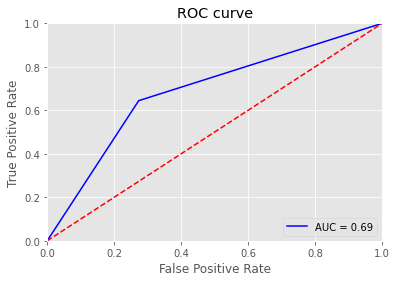

In [37]:
# ROC curve
# code inspired from https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/?fbclid=IwAR0g5dlUGF53mbQQ0h9kwV8Ne9-NzYiGjlYwe72GpHbidMEEPAUD2Sgu1yo
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [38]:
# ^The result is good since the blue curve is aboce the red one - since it indicates a larger numer of true positives than false negatives 